In [48]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

import sklearn

# Import necessary modules
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

# Keras specific
import keras
from keras.models import Sequential
from keras.layers import Dense,Flatten
from tensorflow.keras.utils import to_categorical
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve
from tensorflow.keras.optimizers import RMSprop
from keras.layers import Dense, Dropout,Flatten,Conv2D, MaxPooling2D

In [65]:
data = pd.read_csv("../rawdata/landslide_data.csv")
print(data.shape)


(7482, 16)


## data exploration

FEATTYPE       object
SCALE         float64
FACAFF         object
elevation       int64
aspect        float64
slope         float64
landuse         int64
Period         object
Years_befo     object
Main_Rock_     object
NDVI          float64
distance      float64
total_curv    float64
plan_curv     float64
prof_curv     float64
Label           int64
dtype: object

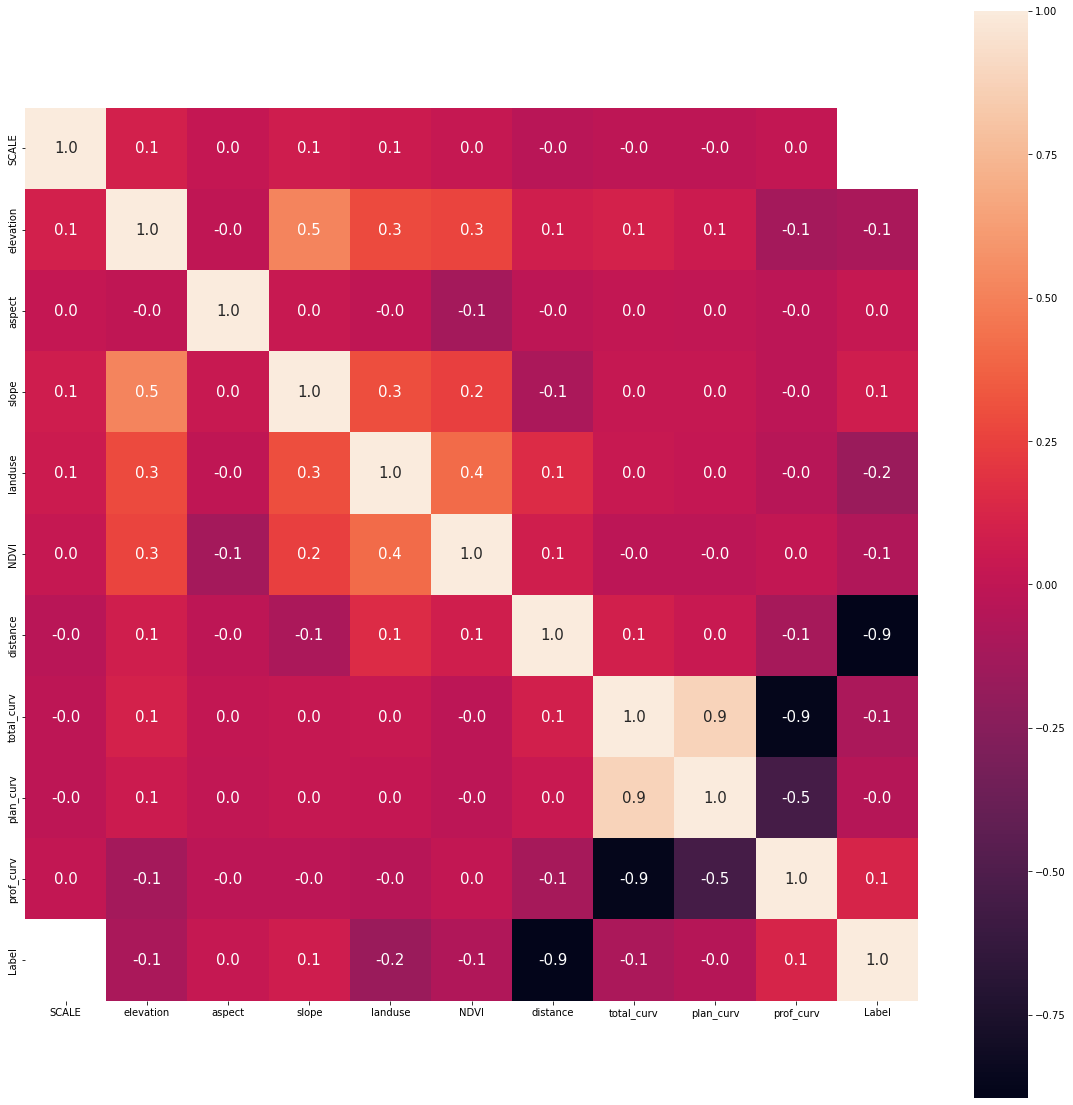

In [66]:
# low correlation
plt.figure(figsize=(20,20))
corr=data.corr()
sns.heatmap(corr, cbar=True, square= True, fmt='.1f', annot=True, annot_kws={'size':15})
data.head()
data.dtypes


## data process

In [67]:
data['FEATTYPE'].unique()

array(['Retaining Wall (Masonry)', 'Fill Slope', 'Soil Cut',
       'Retaining Wall', 'Natural Hillside', 'Others', 'Soil cut',
       'Retaining Wall (Concrete)', 'Disturbed Terrain', 'Soil/Rock Cut',
       'Rock Cut', 'Retaining Wall (Brick)',
       'Retaining Wall (Reinforced Concrete)', 'Soil/rock cut',
       'Disturbed terrain', 'Rock cut', nan], dtype=object)

In [68]:
a=data['FACAFF'].value_counts()
b=a.to_frame()
b.head(15)

,FACAFF
Road,546
Access road,510
Open area,509
Minor footpath,403
Catchwater,170
Squatter dwelling,151
Footpath,132
Pedestrian pavement,108
Village house,106
Nil,83


In [69]:
data['FACAFF'].value_counts(normalize=True)

Road                                      0.145950
Access road                               0.136327
Open area                                 0.136060
Minor footpath                            0.107725
Catchwater                                0.045442
                                            ...   
Indoor carpark                            0.000267
Built-up facilities                       0.000267
Roadside verge                            0.000267
Natural streamcourse                      0.000267
Garden of school, open area of factory    0.000267
Name: FACAFF, Length: 373, dtype: float64

In [70]:
#try replacing according to the top 15 
#reclassify the FACAFF into five categories
def FACAFF_cal(FACAFF_befo):
    if FACAFF_befo == 'Road' or FACAFF_befo == 'Access road' or FACAFF_befo == 'Footpath' or FACAFF_befo == 'Pedestrian pavement'or FACAFF_befo == 'Backlane' or FACAFF_befo == 'Access Road':
        return 0 #road 
    elif FACAFF_befo == 'Catchwater' or FACAFF_befo =='Squatter dwelling' or FACAFF_befo =='Registered squatter dwelling':
        return 1 #water
    elif FACAFF_befo == 'Building' or FACAFF_befo == 'Village house' or FACAFF_befo == 'Squatter structure':
        return 2 #building
    elif  FACAFF_befo == 'Nil':
        return 3 #soil
    else :
        return 4 #other types

In [71]:
#reclassify land use types
def landuse_cal(landuse_befo):
    if landuse_befo <= 54:
        return 'urban'
    elif landuse_befo == 72:
        return 'Shrubland'
    elif landuse_befo == 73 or landuse_befo == 81:
        return 'Grassland'
    elif landuse_befo == 71:
        return 'forest'
    elif landuse_befo == 61:
        return 'Agriculture'
    elif landuse_befo == 74:
        return 'Wetland'
    else :
        return 'water'

In [72]:
#label each type (Y variable)
#this time just categorize into two types, soil/rock cut or not 
def cause_cal(cause_type):
    if cause_type == "Soil Cut" or cause_type == "Soil cut" or cause_type == "Soil/Rock Cut" or cause_type == "Rock Cut" or cause_type == "Soil/rock cut":
        return 1
    else :
        return 0

D:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


,FEATTYPE,SCALE,FACAFF,elevation,aspect,slope,landuse,Period,Years_befo,Main_Rock_,NDVI,distance,total_curv,plan_curv,prof_curv,Label
0,0,1.5,4,52,330.524,2.04472,urban,Quaternary,0-1.8,"Superficial Deposits (Silt, sand and gravel)",0.193857,17.340808,-0.282579,-0.181710,0.100869,1
1,0,18.0,4,1,225.000,1.86081,Agriculture,Quaternary,0-1.8,"Superficial Deposits (Silt, sand and gravel)",0.292597,51.054059,0.282579,0.289513,0.006934,1
2,1,0.5,4,6,149.534,3.05130,Shrubland,Quaternary,0-1.8,"Superficial Deposits (Silt, sand and gravel)",0.339637,130.601425,-0.208863,-0.102582,0.106281,1
3,1,45.0,0,26,346.373,5.24349,urban,Quaternary,0-1.8,"Superficial Deposits (Silt, sand and gravel)",0.194702,384.036599,0.159719,0.161805,0.002086,1
4,1,0.3,4,22,335.999,11.45630,urban,Quaternary,0-1.8,"Superficial Deposits (Silt, sand and gravel)",0.155207,370.113211,-0.651161,-0.205214,0.445947,1


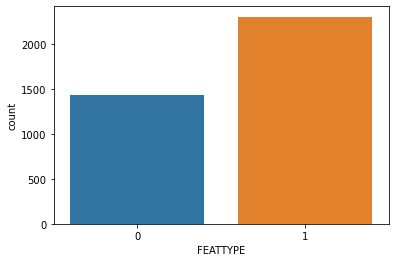

In [73]:
#classify Y variables
data['FEATTYPE'] = data['FEATTYPE'].apply(cause_cal)
#delete non-lanbdslide incidents 
data = data.drop(data[data['Label']==0].index)
#plot data distribution 
sns.countplot(data['FEATTYPE'] )
data['landuse'] = data['landuse'].apply(landuse_cal)
data['FACAFF'] = data['FACAFF'].apply(FACAFF_cal)
data.head()

In [74]:
df2 = pd.get_dummies(data, columns=['Main_Rock_','Period','landuse','FACAFF'])
df2.loc[df2['Label']==0,'SCALE']=0
#check na value
df2.isnull().sum()

def year_cal(Years_befo):
    if Years_befo == '0-1.8':
        return 1.8
    elif Years_befo == '145-199':
        return 145
    elif Years_befo == '359-416':
        return 359
    elif Years_befo == '65-145':
        return 65
    #Years_befo == '299-359'
    else :
        return 299
    
df2['Year'] = df2['Years_befo'].apply(year_cal)

In [75]:
df2=df2.drop(['Label'], axis=1)

In [76]:
df2

,FEATTYPE,SCALE,elevation,aspect,slope,Years_befo,NDVI,distance,total_curv,plan_curv,...,landuse_Wetland,landuse_forest,landuse_urban,landuse_water,FACAFF_0,FACAFF_1,FACAFF_2,FACAFF_3,FACAFF_4,Year
0,0,1.5,52,330.5240,2.04472,0-1.8,0.193857,17.340808,-0.282579,-0.181710,...,0,0,1,0,0,0,0,0,1,1.8
1,0,18.0,1,225.0000,1.86081,0-1.8,0.292597,51.054059,0.282579,0.289513,...,0,0,0,0,0,0,0,0,1,1.8
2,1,0.5,6,149.5340,3.05130,0-1.8,0.339637,130.601425,-0.208863,-0.102582,...,0,0,0,0,0,0,0,0,1,1.8
3,1,45.0,26,346.3730,5.24349,0-1.8,0.194702,384.036599,0.159719,0.161805,...,0,0,1,0,1,0,0,0,0,1.8
4,1,0.3,22,335.9990,11.45630,0-1.8,0.155207,370.113211,-0.651161,-0.205214,...,0,0,1,0,0,0,0,0,1,1.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3736,1,10.0,12,324.7820,3.21890,299-359,0.332246,90.727100,0.012286,-0.047178,...,0,0,1,0,0,0,0,0,1,299.0
3737,1,0.0,11,200.5560,1.32283,299-359,0.200553,73.099615,-0.159719,0.013185,...,0,0,1,0,0,0,1,0,0,299.0
3738,0,50.0,18,319.2360,2.96190,299-359,0.083345,106.610670,0.012286,0.028286,...,0,0,1,0,0,0,0,0,1,299.0
3739,0,1.0,16,312.2900,6.15154,299-359,0.105991,29.004583,0.000000,0.058611,...,0,0,1,0,0,0,0,0,1,299.0


In [77]:
col= df2.columns[pd.np.r_[1:5,6:37]]
print(col)
#get x value
x = np.array(df2[col])
x.shape

Index(['SCALE', 'elevation', 'aspect', 'slope', 'NDVI', 'distance',
       'total_curv', 'plan_curv', 'prof_curv', 'Main_Rock__Granitic Rocks',
       'Main_Rock__Granodiorite',
       'Main_Rock__Graphitic siltstone, sandstone and marble',
       'Main_Rock__Quartz sandstone, siltstone with conglomerate',
       'Main_Rock__Red conglomerate and coarse sandstone with siltstone',
       'Main_Rock__Sandstone, siltstone and mudstone',
       'Main_Rock__Superficial Deposits (Silt, sand and gravel)',
       'Main_Rock__Tuff and Lava', 'Period_Carboniferous', 'Period_Cretaceous',
       'Period_Devonian', 'Period_Jurassic', 'Period_Quaternary',
       'landuse_Agriculture', 'landuse_Grassland', 'landuse_Shrubland',
       'landuse_Wetland', 'landuse_forest', 'landuse_urban', 'landuse_water',
       'FACAFF_0', 'FACAFF_1', 'FACAFF_2', 'FACAFF_3', 'FACAFF_4', 'Year'],
      dtype='object')


C:\Users\zheng\AppData\Local\Temp/ipykernel_58304/2763973391.py:1: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  col= df2.columns[pd.np.r_[1:5,6:37]]


(3741, 35)

In [78]:
# get y value
y=np.array(df2['FEATTYPE'])
y

array([0, 0, 1, ..., 0, 0, 1], dtype=int64)

## Principal Component Analysis

In [79]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=0)

principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [80]:
finalDf = pd.concat([principalDf, df2['FEATTYPE']], axis = 1)
finalDf

,principal component 1,principal component 2,FEATTYPE
0,-265.683365,-53.993755,0
1,-233.064876,-38.827949,0
2,-152.883919,-51.824675,1
3,97.838045,11.126034,1
4,86.701940,-34.573852,1
...,...,...,...
3736,-193.302726,-42.224680,1
3737,-210.696985,-54.541108,1
3738,-179.988652,-1.136259,0
3739,-254.418621,-54.963073,0


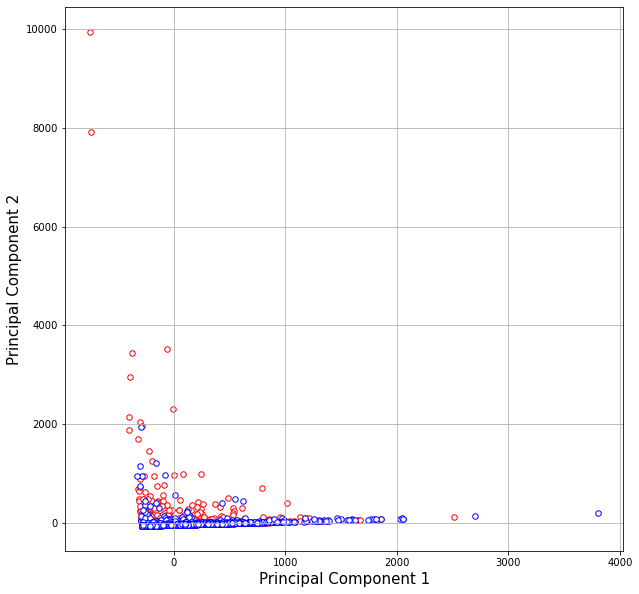

In [81]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
# ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1]
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['FEATTYPE'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1'],
               finalDf.loc[indicesToKeep, 'principal component 2'],
               c = 'white',
#                c = color,
               edgecolors = color,
               s = 30,
#                alpha = 0.25
              )
#ax.legend(['Landslide','No Landslide'], fontsize =16)
ax.grid()
plt.show()

## machine learning model

##  1. k-Nearest Neighbor

In [82]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


In [83]:
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size = 0.3, stratify = y, random_state = 4)


In [84]:
# We need to do feature scaling first.
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import MinMaxScaler
sc = StandardScaler()
#sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [85]:
model = KNeighborsClassifier()

param_grid = { 
    'n_neighbors': [3,5,11,19],
    'weights': ['uniform', 'distance'],
    'metric' : ['euclidean', 'manhattan'],
}

grid = GridSearchCV(estimator=model, param_grid=param_grid)

grid.fit(X_train, y_train.ravel())

metric = grid.best_estimator_.metric
n_neighbors = grid.best_estimator_.n_neighbors
weights = grid.best_estimator_.weights

# summarize the results of the grid search
print('Best score:', grid.best_score_)
print('Best hyperparameters:',grid.best_params_)

Best score: 0.6371411265015399
Best hyperparameters: {'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'uniform'}


Performance metrics

In [86]:
knn = KNeighborsClassifier(metric=metric, n_neighbors=n_neighbors, weights=weights).fit(X_train, y_train.ravel())
knn_pred = knn.predict(X_test)
knn_proba = knn.predict_proba(X_test)

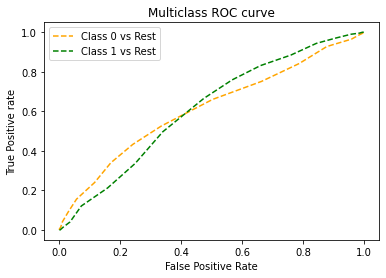

In [87]:
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 2

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, knn_proba[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')

plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);

In [88]:
knn_cls_precision, knn_cls_recall, knn_cls_f1, _ = precision_recall_fscore_support(y_test, knn_pred, average=None, labels=[0,1])

In [89]:
knn_conf_mat = confusion_matrix(y_test, knn_pred)
knn_acc = accuracy_score(y_test, knn_pred)
print('k Nearest Neighbors:')
print('Accuracy:',knn_acc)
#print('ROC AUC=%.4f' % (knn_roc_auc))

k Nearest Neighbors:
Accuracy: 0.6429207479964381


Confusion Matrix:


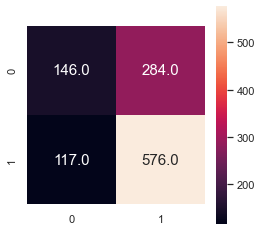

In [90]:
array = confusion_matrix(y_test, knn_pred)

knn_cm = pd.DataFrame(array, range(2), range(2))

plt.figure(figsize=(4,4))
sns.set(font_scale=1) # for label size
sns.heatmap(knn_cm, annot=True, annot_kws={"size": 15}, cbar=True, square= True, fmt='.1f') # font size

print('Confusion Matrix:')
plt.show()

In [91]:
for i in range(n_class): 
    print(i)
    print('Precision  = %.4f ' % (knn_cls_precision[i]))
    print('Recall on Y label = %.4f ' % (knn_cls_recall[i]))
    print('F1 on Y label = %.4f ' % (knn_cls_f1[i]))
    print('----------------------------')

0
Precision  = 0.5551 
Recall on Y label = 0.3395 
F1 on Y label = 0.4214 
----------------------------
1
Precision  = 0.6698 
Recall on Y label = 0.8312 
F1 on Y label = 0.7418 
----------------------------


## 2. Support Vector Machine

Hyperparameter optimization

In [159]:
np.logspace(-3,3,7)

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])

In [104]:
#not run
model = SVC(random_state=0, probability=True)

param_grid={'C':np.logspace(-3,3,7),
            'kernel': ['poly', 'rbf', 'sigmoid'],
          'gamma': [0.001, 0.01, 1],
           }
grid = GridSearchCV(estimator=model, param_grid=param_grid)

grid.fit(X_train, y_train.ravel())

C = grid.best_estimator_.C
gamma = grid.best_estimator_.gamma
kernel = grid.best_estimator_.kernel

# summarize the results of the grid search
print('Best score:', grid.best_score_)
print('Best hyperparameters:',grid.best_params_)

KeyboardInterrupt: 

Train on opmtimal hyperparameters

In [143]:
svm = SVC(random_state =0, probability = True,C=C,kernel = kernel).fit(X_train,y_train.ravel())

Get predictions and probabilities on test set

In [144]:
svm_pred = svm.predict(X_test)
svm_proba = svm.predict_proba(X_test)

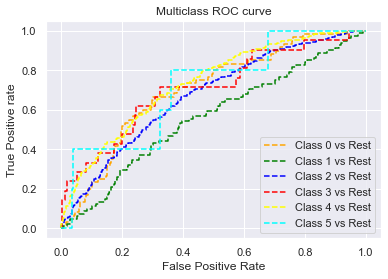

In [145]:
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 6

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, svm_proba[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='yellow', label='Class 4 vs Rest')
plt.plot(fpr[5], tpr[5], linestyle='--',color='aqua', label='Class 5 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);

In [146]:
svm_conf_mat = confusion_matrix(y_test, svm_pred)
svm_acc = accuracy_score(y_test, svm_pred)

Confusion Matrix:


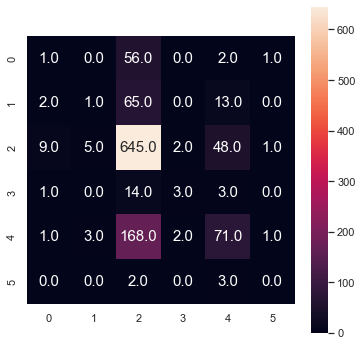

In [149]:
array = confusion_matrix(y_test, svm_pred)

svm_cm = pd.DataFrame(array, range(6), range(6))

plt.figure(figsize=(6,6))
sns.set(font_scale=1) # for label size
sns.heatmap(svm_cm, annot=True, annot_kws={"size": 15}, cbar=True, square= True, fmt='.1f') # font size

print('Confusion Matrix:')
plt.show()

In [150]:
svm_cls_precision, svm_cls_recall, svm_cls_f1, _ = precision_recall_fscore_support(y_test, svm_pred, average=None, labels=[0,1])
for i in range(n_class): 
    print(i)
    print('Precision  = %.4f ' % (svm_cls_precision[i]))
    print('Recall on Y label = %.4f ' % (svm_cls_recall[i]))
    print('F1 on Y label = %.4f ' % (svm_cls_f1[i]))
    print('----------------------------')

0
Precision  = 0.0714 
Recall on Y label = 0.0167 
F1 on Y label = 0.0270 
----------------------------
1
Precision  = 0.1111 
Recall on Y label = 0.0123 
F1 on Y label = 0.0222 
----------------------------
2
Precision  = 0.6789 
Recall on Y label = 0.9085 
F1 on Y label = 0.7771 
----------------------------
3
Precision  = 0.4286 
Recall on Y label = 0.1429 
F1 on Y label = 0.2143 
----------------------------
4
Precision  = 0.5071 
Recall on Y label = 0.2886 
F1 on Y label = 0.3679 
----------------------------
5
Precision  = 0.0000 
Recall on Y label = 0.0000 
F1 on Y label = 0.0000 
----------------------------


## 3. Artificial Neural Network

In [ ]:
#not run yet
# multi-linear percetion
# 100 sample, 100 epoch
# keras: multi-layer (not incude cnn) 
# cuda
# tod:aggravate data, experiment with small batch 
# keras cuda 
model = MLPClassifier(random_state=0, max_iter=100)

param_grid={
            'hidden_layer_sizes': np.arange(10, 50,5),
            'activation': ['identity', 'logistic', 'tanh', 'relu'],
            'alpha' : 10.0 ** -np.arange(1, 5),
            'learning_rate': ['constant', 'adaptive']
           }

grid = GridSearchCV(estimator=model, param_grid=param_grid)

grid.fit(X_train, y_train.ravel())

hidden_layer_sizes = grid.best_estimator_.hidden_layer_sizes
activation = grid.best_estimator_.activation
alpha = grid.best_estimator_.alpha
learning_rate = grid.best_estimator_.learning_rate

# summarize the results of the grid search
print('Best score:', grid.best_score_)
print('Best hyperparameters:',grid.best_params_)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_m

In [ ]:
mlp = MLPClassifier(random_state=0, max_iter = 1000, activation = activation, alpha = alpha, hidden_layer_sizes = hidden_layer_sizes, learning_rate=learning_rate).fit(X_train,y_train.ravel())

In [ ]:
mlp_pred = mlp.predict(X_test)
mlp_proba = mlp.predict_proba(X_test)

In [ ]:
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 6

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, mlp_proba[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='yellow', label='Class 4 vs Rest')
plt.plot(fpr[5], tpr[5], linestyle='--',color='aqua', label='Class 5 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')

In [60]:
mlp_conf_mat = confusion_matrix(y_test, mlp_pred)
mlp_acc = accuracy_score(y_test, mlp_pred)
mlp_roc_auc = roc_auc_score(y_test, mlp_proba[:,1])

mlp_fpr, mlp_tpr, _ = roc_curve(y_test, mlp_proba[:,1])
mlp_precision, mlp_recall, _ = precision_recall_curve(y_test, mlp_proba[:,1])

mlp_cls_precision, mlp_cls_recall, mlp_cls_f1, _ = precision_recall_fscore_support(y_test, mlp_pred, average=None, labels=[0,1])

print('Multi Layer Perceptron :')
print('\nConfusion matrix:\n',mlp_conf_mat,'\n')
print('Accuracy:',mlp_acc)
print('ROC AUC=%.4f' % (mlp_roc_auc))
print('Precision on (Landslide = 0) = %.4f ' % (mlp_cls_precision[0]))
print('Recall on (Landslide = 0) = %.4f ' % (mlp_cls_recall[0]))
print('F1 on (Landslide = 0) = %.4f' % (mlp_cls_f1[0]))
print('Precision on (Landslide = 1) = %.4f ' % (mlp_cls_precision[1]))
print('Recall on (Landslide = 1) = %.4f ' % (mlp_cls_recall[1]))
print('F1 on (Landslide = 1) = %.4f ' % (mlp_cls_f1[1]))

Multi Layer Perceptron :

Confusion matrix:
 [[1142    0]
 [   1 1102]] 

Accuracy: 0.999554565701559
ROC AUC=1.0000
Precision on (Landslide = 0) = 0.9991 
Recall on (Landslide = 0) = 1.0000 
F1 on (Landslide = 0) = 0.9996
Precision on (Landslide = 1) = 1.0000 
Recall on (Landslide = 1) = 0.9991 
F1 on (Landslide = 1) = 0.9995 


## 4. Random Forest

In [77]:
model = RandomForestClassifier(random_state=0)

param_grid = { 
    'n_estimators': [200, 300, 400, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : np.arange(10,30,2),
    'criterion' :['gini', 'entropy']
}

grid = GridSearchCV(estimator=model, param_grid=param_grid)

grid.fit(X_train, y_train.ravel())

n_estimators = grid.best_estimator_.n_estimators
criterion = grid.best_estimator_.criterion
max_depth = grid.best_estimator_.max_depth
max_features = grid.best_estimator_.max_features

# summarize the results of the grid search
print('Best score:', grid.best_score_)
print('Best hyperparameters:',grid.best_params_)

KeyboardInterrupt: 

In [62]:
rf = RandomForestClassifier(random_state=0, criterion=criterion, max_depth=max_depth, max_features=max_features, n_estimators = n_estimators).fit(X_train,y_train.ravel())

In [63]:
rf_pred = rf.predict(X_test)
rf_proba = rf.predict_proba(X_test)

In [64]:
rf_conf_mat = confusion_matrix(y_test, rf_pred)
rf_acc = accuracy_score(y_test, rf_pred)
rf_roc_auc = roc_auc_score(y_test, rf_proba[:,1])

rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_proba[:,1])
rf_precision, rf_recall, _ = precision_recall_curve(y_test, rf_proba[:,1])

rf_cls_precision, rf_cls_recall, rf_cls_f1, _ = precision_recall_fscore_support(y_test, rf_pred, average=None, labels=[0,1])

print('Random Forest :')
print('\nConfusion matrix:\n',rf_conf_mat,'\n')
print('Accuracy:',rf_acc)
print('ROC AUC=%.4f' % (rf_roc_auc))
print('Precision on (Landslide = 0) = %.4f ' % (rf_cls_precision[0]))
print('Recall on (Landslide = 0) = %.4f ' % (rf_cls_recall[0]))
print('F1 on (Landslide = 0) = %.4f' % (rf_cls_f1[0]))
print('Precision on (Landslide = 1) = %.4f ' % (rf_cls_precision[1]))
print('Recall on (Landslide = 1) = %.4f ' % (rf_cls_recall[1]))
print('F1 on (Landslide = 1) = %.4f ' % (rf_cls_f1[1]))

Random Forest :

Confusion matrix:
 [[1142    0]
 [   0 1103]] 

Accuracy: 1.0
ROC AUC=1.0000
Precision on (Landslide = 0) = 1.0000 
Recall on (Landslide = 0) = 1.0000 
F1 on (Landslide = 0) = 1.0000
Precision on (Landslide = 1) = 1.0000 
Recall on (Landslide = 1) = 1.0000 
F1 on (Landslide = 1) = 1.0000 


## 5. decision tree

In [100]:
model = DecisionTreeClassifier(random_state=0)

param_grid = { 
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : np.arange(10,40,5),
    'criterion' :['gini', 'entropy']
}

grid = GridSearchCV(estimator=model, param_grid=param_grid)

grid.fit(X_train, y_train.ravel())

criterion = grid.best_estimator_.criterion
max_depth = grid.best_estimator_.max_depth
max_features = grid.best_estimator_.max_features

# summarize the results of the grid search
print('Best score:', grid.best_score_)
print('Best hyperparameters:',grid.best_params_)

Best score: 0.6306547662487411
Best hyperparameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto'}


In [101]:
dt = DecisionTreeClassifier(random_state=0, criterion = criterion, max_depth=max_depth, max_features=max_features).fit(X_train, y_train.ravel())

In [102]:
dt_pred = dt.predict(X_test)
dt_proba = dt.predict_proba(X_test)

In [103]:
dt_conf_mat = confusion_matrix(y_test, dt_pred)
dt_acc = accuracy_score(y_test, dt_pred)
dt_roc_auc = roc_auc_score(y_test, dt_proba[:,1])

dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_proba[:,1])
dt_precision, dt_recall, _ = precision_recall_curve(y_test, dt_proba[:,1])

dt_cls_precision, dt_cls_recall, dt_cls_f1, _ = precision_recall_fscore_support(y_test, dt_pred, average=None, labels=[0,1])

print('Decision Tree:')
print('\nConfusion matrix:\n',dt_conf_mat,'\n')
print('Accuracy:',dt_acc)
print('ROC AUC=%.4f' % (dt_roc_auc))
print('Precision on (Landslide = 0) = %.4f ' % (dt_cls_precision[0]))
print('Recall on (Landslide = 0) = %.4f ' % (dt_cls_recall[0]))
print('F1 on (Landslide = 0) = %.4f' % (dt_cls_f1[0]))
print('Precision on (Landslide = 1) = %.4f ' % (dt_cls_precision[1]))
print('Recall on (Landslide = 1) = %.4f ' % (dt_cls_recall[1]))
print('F1 on (Landslide = 1) = %.4f ' % (dt_cls_f1[1]))

Decision Tree:

Confusion matrix:
 [[148 282]
 [180 513]] 

Accuracy: 0.5886019590382903
ROC AUC=0.5462
Precision on (Landslide = 0) = 0.4512 
Recall on (Landslide = 0) = 0.3442 
F1 on (Landslide = 0) = 0.3905
Precision on (Landslide = 1) = 0.6453 
Recall on (Landslide = 1) = 0.7403 
F1 on (Landslide = 1) = 0.6895 


## Export performance metrics of models

In [82]:
perf_metr = pd.DataFrame(index = ['K Nearest Neighbors',
                        'Support Vector Machine',
                        'Multi Layer Perceptron',
                        'Decision Tree',
                        'Random Forest',
                       ],
             columns = ['Accuracy', 
                        'ROC AUC', 
                        'Precision on Landlside=0', 
                        'Recall on Landlside=0', 
                        'F1-score on Landlside=0', 
                        'Precision on Landlside=1', 
                        'Recall on Landlside=1', 
                        'F1-score on Landlside=1']
            )

In [83]:
knn_perf_metr = pd.Series([knn_acc, knn_roc_auc, knn_cls_precision[0], knn_cls_recall[0], knn_cls_f1[0], knn_cls_precision[0],knn_cls_recall[0], knn_cls_f1[0]])
svm_perf_metr = pd.Series([svm_acc, svm_roc_auc, svm_cls_precision[0], svm_cls_recall[0], svm_cls_f1[0], svm_cls_precision[0],svm_cls_recall[0], svm_cls_f1[0]])
mlp_perf_metr = pd.Series([mlp_acc, mlp_roc_auc, mlp_cls_precision[0], mlp_cls_recall[0], mlp_cls_f1[0], mlp_cls_precision[0],mlp_cls_recall[0], mlp_cls_f1[0]])
dt_perf_metr = pd.Series([dt_acc, dt_roc_auc, dt_cls_precision[0], dt_cls_recall[0], dt_cls_f1[0], dt_cls_precision[0],dt_cls_recall[0], dt_cls_f1[0]])
rf_perf_metr = pd.Series([rf_acc, rf_roc_auc, rf_cls_precision[0], rf_cls_recall[0], rf_cls_f1[0], rf_cls_precision[0],rf_cls_recall[0], rf_cls_f1[0]])

In [84]:
perf_metr.loc['K Nearest Neighbors',:] = knn_perf_metr.values
perf_metr.loc[ 'Support Vector Machine',:] = svm_perf_metr.values
perf_metr.loc['Multi Layer Perceptron',:] = mlp_perf_metr.values
perf_metr.loc['Decision Tree',:] = dt_perf_metr.values
perf_metr.loc['Random Forest',:] = rf_perf_metr.values

In [85]:
perf_metr = perf_metr.astype(float).round(4)

In [86]:
perf_metr

,Accuracy,ROC AUC,Precision on Landlside=0,Recall on Landlside=0,F1-score on Landlside=0,Precision on Landlside=1,Recall on Landlside=1,F1-score on Landlside=1
K Nearest Neighbors,0.9626,0.9828,0.9315,1.0000,0.9645,0.9315,1.0000,0.9645
Support Vector Machine,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
Multi Layer Perceptron,0.9996,1.0000,0.9991,1.0000,0.9996,0.9991,1.0000,0.9996
Decision Tree,0.9559,0.9647,0.9278,0.9904,0.9581,0.9278,0.9904,0.9581
Random Forest,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


## ROC-AUC curves

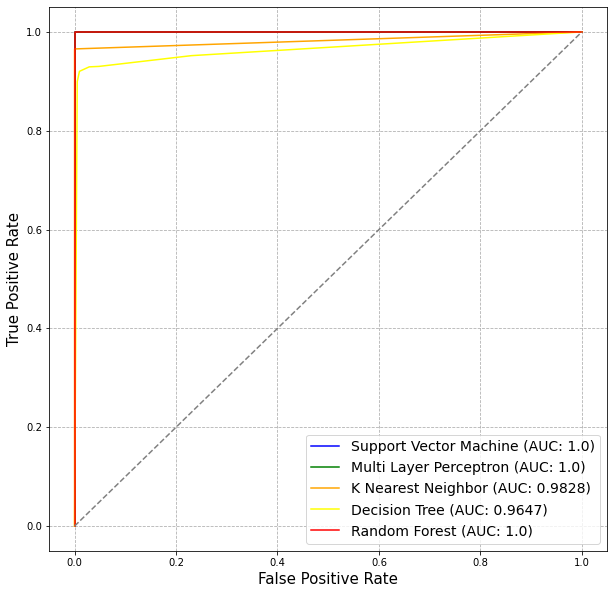

In [89]:

svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_proba[:,1])
mlp_fpr, mlp_tpr, _ = roc_curve(y_test, mlp_proba[:,1])
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_proba[:,1])

fig, ax = plt.subplots(1, figsize=(10,10))

# fig.figure(figsize=(10,10))

# plot the roc curve for the model
# pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
ax.plot(svm_fpr, svm_tpr,  color = 'blue', label='Support Vector Machine (AUC: ' + str(np.round(svm_roc_auc,4))+')')
ax.plot(mlp_fpr, mlp_tpr, color = 'green', label='Multi Layer Perceptron (AUC: ' + str(np.round(mlp_roc_auc,4))+')')
ax.plot(knn_fpr, knn_tpr,  color = 'orange',label='K Nearest Neighbor (AUC: ' + str(np.round(knn_roc_auc,4))+')')
ax.plot(dt_fpr, dt_tpr,  color = 'yellow', label='Decision Tree (AUC: ' + str(np.round(dt_roc_auc,4))+')')
ax.plot(rf_fpr, rf_tpr,  color = 'red', label='Random Forest (AUC: ' + str(np.round(rf_roc_auc,4))+')')
ax.plot([0,1],[0,1], color='grey', linestyle='dashed')

# axis labels
ax.set_xlabel('False Positive Rate', fontsize=15)
ax.set_ylabel('True Positive Rate', fontsize=15)

# show the legend
# plt.legend()

handles,labels = ax.get_legend_handles_labels()


handles = [handles[0], handles[1], handles[2], handles[3], handles[4]]
labels = [labels[0], labels[1], labels[2], labels[3], labels[4]]

ax.grid(linestyle='dashed')
ax.legend(handles,labels, fontsize=14)

plt.show()

### deep learning model

## 1. CNN 

In [92]:
print(X_train.shape)


(2618, 35)


In [93]:
model = Sequential()
model.add(Dense(80, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(80, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.add(Flatten())

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])
history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=1,
                    verbose=1,
                    validation_data=(X_test, y_test))

41/41 [==============================] - 1s 5ms/step - loss: 7.3584e-08 - accuracy: 0.4500 - val_loss: 7.3564e-08 - val_accuracy: 0.4773


In [97]:
model = Sequential()
model.add(Dense(80, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(80, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.add(Flatten())

model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [98]:
model.fit(X_train, y_train,epochs=50)

Epoch 1/50
82/82 [==============================] - 1s 2ms/step - loss: 0.6489 - accuracy: 0.6218
Epoch 2/50
82/82 [==============================] - 0s 1ms/step - loss: 0.6180 - accuracy: 0.6597
Epoch 3/50
82/82 [==============================] - 0s 2ms/step - loss: 0.6036 - accuracy: 0.6784
Epoch 4/50
82/82 [==============================] - 0s 1ms/step - loss: 0.5919 - accuracy: 0.6883
Epoch 5/50
82/82 [==============================] - 0s 2ms/step - loss: 0.5865 - accuracy: 0.6891
Epoch 6/50
82/82 [==============================] - 0s 2ms/step - loss: 0.5714 - accuracy: 0.6994
Epoch 7/50
82/82 [==============================] - 0s 2ms/step - loss: 0.5616 - accuracy: 0.7024
Epoch 8/50
82/82 [==============================] - 0s 2ms/step - loss: 0.5515 - accuracy: 0.7089
Epoch 9/50
82/82 [==============================] - 0s 2ms/step - loss: 0.5418 - accuracy: 0.7147
Epoch 10/50
82/82 [==============================] - 0s 2ms/step - loss: 0.5267 - accuracy: 0.7353
Epoch 11/50
82/82 [

In [99]:
results = model.evaluate(X_test, y_test, batch_size=128)

9/9 [==============================] - 0s 1ms/step - loss: 1.5511 - accuracy: 0.6162
